Linus code

In [1]:
# Install package to be able to save keras weights
pip install h5py

In [2]:
pip install nibabel

In [3]:
# Mount google drive
from google.colab import drive
import os
drive.mount('my_drive', force_remount=True)

Mounted at my_drive


In [14]:
from keras.callbacks import Callback
import keras.backend as K
import json
import psutil
import os

def print_memory_use():
    '''
    Function which prints current python memory usage
    '''
    process = psutil.Process(os.getpid())
    print(process.memory_info().rss/1e9)

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

# fixme: skulle gå att göra bättre igenom att skicka med en tex tuple med titlarna
# och returnera ett matplotlib-objekt istället för då hade man inte behövt ha olika
# funktioner för "plot_modalities" och "plt_OHE" och också kunna ha två stycken figurer med 
# 2*2 subplots i en cell.
def plot_modalities(x):
    # Make sure input data is of correct shape
    assert x.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(x[:,:,0])
    plt.axis('off')
    plt.title('T1')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(x[:,:,1])
    plt.axis('off')
    plt.title('T1ce')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(x[:,:,2])
    plt.axis('off')
    plt.title('T2')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(x[:,:,3])
    plt.axis('off')
    plt.title('FLAIR')
    plt.colorbar()
    plt.show()

def plot_OHE(y):
    # Make sure input data is of correct shape
    assert y.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(y[:,:,0])
    plt.axis('off')
    plt.title('Null')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(y[:,:,1])
    plt.axis('off')
    plt.title('"Necrotic and non-enhancing tumor core"')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(y[:,:,2])
    plt.axis('off')
    plt.title('Edema')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(y[:,:,3])
    plt.axis('off')
    plt.title('GD-enhancing tumor')
    plt.colorbar()
    plt.show()

def shift_and_scale(x):
    assert len(x.shape) == 2, 'The input must be 2 dimensional'
    #assert np.std(x) != 0, 'Cant divide by zero'
    result = x - np.mean(x)
    
    # This is a really ugly hack
    if np.std(x) == 0:
      result /= 1
    else:
      result /= np.std(x)
    return result

def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

#fixme: I don't know if providing this mapping is necessary
# probably could be provided inside function instead.
def OHE_uncoding(y, mapping):
    result = np.argmax(y, axis=2)
    labels = mapping.keys()
    temp = np.zeros(result.shape)
    for i, label in enumerate(labels):
        ind = result == i
        temp[ind] = label
    return temp

def IoU_wholeTumor(y_true, y_pred):
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    
    y_pred[:,:,0] = np.logical_not(y_pred[:,:,0]) 
    y_true[:,:,0] = np.logical_not(y_true[:,:,0])
    
    intersection = np.logical_and(y_pred[:,:,0], y_true[:,:,0])
    union = np.logical_or(y_true[:,:,0], y_pred[:,:,0])
    
    size_int = np.count_nonzero(intersection)
    size_uni = np.count_nonzero(union)
    
    return size_int/size_uni

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + 1e-8)

def confusion_matrix(y_true, y_pred):
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    p_00 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,0]))
    p_11 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,1]))
    p_22 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,2]))
    p_33 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,3]))

    f_10 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,1]))
    f_20 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,2]))
    f_30 = np.count_nonzero(np.logical_and(y_pred[:,:,0], y_true[:,:,3]))

    f_01 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,0]))
    f_21 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,2]))
    f_31 = np.count_nonzero(np.logical_and(y_pred[:,:,1], y_true[:,:,3]))

    f_02 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,0]))
    f_12 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,1]))
    f_32 = np.count_nonzero(np.logical_and(y_pred[:,:,2], y_true[:,:,3]))

    f_03 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,0]))
    f_13 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,1]))
    f_23 = np.count_nonzero(np.logical_and(y_pred[:,:,3], y_true[:,:,2]))

    conf_matrix = np.array([p_00, f_01, f_02, f_03,
                            f_10,p_11, f_12, f_13, 
                            f_20, f_21, p_22, f_23, 
                            f_30, f_31, f_32, p_33])
    conf_matrix = conf_matrix.reshape(4,4)
    
    return conf_matrix

def reset_config(config, config_path=None, weights_path=None):
    new_config = config
    if weights_path:
        assert type(weights_path) == str, 'The weight path must be a string'
        new_config['weights_path'] = weights_path
    if config_path:
        assert type(config_path) == str, 'The config path must be a string'
        new_config['config_path'] = config_path
    new_config['history']['training_samples_used'] = 0
    new_config['history']['loss'] = []
    new_config['history']['val_loss'] = []
    new_config['keep_training'] = False

class CallbackJSON(Callback):
    """ CallbackJSON descends from Callback
        and is used to write the number of training samples that the model has been trained on
        and the loss for a epoch
    """
    def __init__(self, config):
        """Save params in constructor
        config: Is a dictionary loaded from a JSON file which is used to keep track of training
        """
        self.config = config
        self.config_path = config['config_path']

    def on_epoch_end(self, epoch, logs):
        """
        Updates the history of the config dict and saves it to a file
        """
        # How many effective training samples have been used
        self.config['history']['training_samples_used'] += self.config['samples_used']
        
        # Logs the loss of the current epoch
        self.config['history']['loss'].append(logs['loss'])
        #fixme: add the same code but for "val_loss"
        self.config['history']['val_loss'].append(logs['val_loss'])
        
        print_memory_use()
        # Save new config file
        with open(self.config_path, "w") as f:
            f.write(json.dumps(self.config))

def load_patients(i, j, num_classes, base_path=""):
    assert j >= i, 'j>i has to be true, you have given an invalid range of patients.'
    
    path = base_path + "MICCAI_BraTS_2019_Data_Training/*/*/*"
    
    wild_t1 = path + "_t1.nii.gz"
    wild_t1ce = path + "_t1ce.nii.gz"
    wild_t2 = path + "_t2.nii.gz"
    wild_flair = path + "_flair.nii.gz"
    wild_gt = path + "_seg.nii.gz"

    t1_paths = glob.glob(wild_t1)
    t1ce_paths = glob.glob(wild_t1ce)
    t2_paths = glob.glob(wild_t2)
    flair_paths = glob.glob(wild_flair)
    gt_paths = glob.glob(wild_gt)

    num_patients = j - i
    ind = []
    num_non_empty_slices = 0

    for i in range(i, i + num_patients):
      path_gt = gt_paths[i]
      img_gt = nib.load(path_gt)
      img_gt = img_gt.get_fdata()

      curr_patient = []
      # quick and dirty way to only get slices with tumor
      for j in range(img_gt.shape[-1]):
        if len(np.unique(img_gt[:,:,j])) >= num_classes:
            curr_patient.append(j)
            num_non_empty_slices += 1
      ind.append(curr_patient)

    image_data = np.zeros((4, 240, 240, num_non_empty_slices))
    labels = np.zeros((num_non_empty_slices, 240, 240))
    OHE_labels = np.zeros((num_non_empty_slices, 240, 240, 4))
    next_ind = 0

    for i in range(num_patients):
      print('Patient: ' + str(i))
      curr_ind = ind[i]

      path_t1 = t1_paths[i]
      path_t1ce = t1ce_paths[i]
      path_t2 = t2_paths[i]
      path_flair = flair_paths[i]
      path_gt = gt_paths[i]

      img_t1 = nib.load(path_t1)
      img_t1ce = nib.load(path_t1ce)
      img_t2 = nib.load(path_t2)
      img_flair = nib.load(path_flair)
      img_gt = nib.load(path_gt)

      img_t1 = img_t1.get_fdata()
      img_t1ce = img_t1ce.get_fdata()
      img_t2 = img_t2.get_fdata()
      img_flair = img_flair.get_fdata()
      img_gt = img_gt.get_fdata()

      temp = 0
      for i, x in enumerate(curr_ind):
        image_data[0, :, :, next_ind + i] = img_t1[:,:,x]
        image_data[1, :, :, next_ind + i] = img_t1ce[:,:,x]
        image_data[2, :, :, next_ind + i] = img_t2[:,:,x]
        image_data[3, :, :, next_ind + i] = img_flair[:,:,x]
        labels[next_ind + i,:,:] = img_gt[:,:,x]
        temp += 1
      next_ind += temp

    # I have here chosen to do shift and scale per image, 
    # which is not the only way to do normalization.
    for j in range(num_non_empty_slices):
        # shift and scale data
        image_data[0, :, :, j] = shift_and_scale(image_data[0, :, :, j])
        image_data[1, :, :, j] = shift_and_scale(image_data[1, :, :, j])
        image_data[2, :, :, j] = shift_and_scale(image_data[2, :, :, j])
        image_data[3, :, :, j] = shift_and_scale(image_data[3, :, :, j])

        OHE_labels[j, :, :, :] = OHE(labels[j, :, :], mapping)

    # The last axis will become the first axis
    image_data = np.moveaxis(image_data, -1, 0)
    image_data = np.moveaxis(image_data, 1, 3)
    return (image_data, OHE_labels)

import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1, learning_rate=1e-4):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Softmax(axis=-1)(permute)
  
  model = Model(input = inputs, output = activation)
  model.compile(optimizer = Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics=[dice_coefficient])
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

print('Finished')
print_memory_use()

Finished
2.50904576


In [2]:
from my_lib import *
from os import listdir
import os

# Set name of who is running the script to determine which path to use
name = "linus"

# Code snippet to fix that colab notebook and local notebook access data
# through different paths
var = os.uname()
run_on_colab = var[0] == "Linux"

carl_path = "/content/my_drive/My Drive/Plugg/"
linus_path = "/content/my_drive/My Drive/"

if name == "linus":
  path = linus_path
else:
  path = carl_path

if run_on_colab:
    base_path = path + "EXJOBB"
else:
    base_path = ''

# Much cleaner loading of patients
train_data = load_patients(i=0, j=10, num_classes=4, base_path=base_path)
val_data = load_patients(i=255, j=260, num_classes=4, base_path=base_path)
#test_data = load_patients(i=285, j=334, num_classes=4)
print('Finished')
print_memory_use()

Patient: 0
Patient: 1
Patient: 2
Patient: 3
Patient: 4
Patient: 5
Patient: 6
Patient: 7
Patient: 8
Patient: 9
Patient: 0
Patient: 1
Patient: 2
Patient: 3
Patient: 4


Separate input and labels and validate that the loading of the data has been done correctly

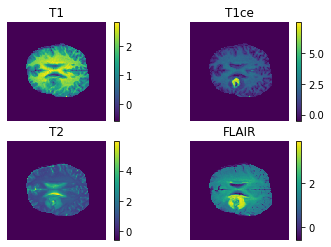

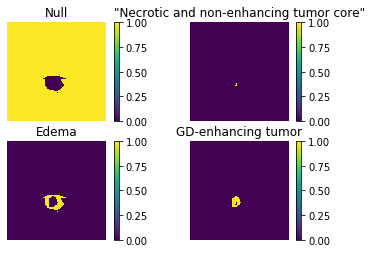

In [5]:
X_train = train_data[0]
Y_train = train_data[1]

X_val = val_data[0]
Y_val = val_data[1]

# This will show a slice of a patient
ind = 48
patient = X_train[ind, :, :, :]
patient_labels = Y_train[ind, :, :, :]
plot_modalities(patient)
plot_OHE(patient_labels)


# New main training cell

In [7]:
# Load config file to session here
if run_on_colab:
    config_path = path + "EXJOBB/training_sessions/trainin_tumor_slices_only/config.json"
    weights_path = path + "EXJOBB/training_sessions/trainin_tumor_slices_only/weights.json"
    config_path = "/content/my_drive/My Drive/EXJOBB/training_sessions/tumor_slices_with_all_classes/config.json"
else:
    config_path = "config_0.json"

with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# Reset file to empty loss-values and/or change paths to config and weights
weights_path = "/content/my_drive/My Drive/EXJOBB/training_sessions/tumor_slices_with_all_classes/weights.h5"
#reset_config(config, config_path = config_path, weights_path=weights_path)

print(config)

{'weights_path': 'Training_session_0/session_0_weights.h5', 'config_path': 'Training_session_0/config_1.json', 'samples_used': 90, 'keep_training': False, 'history': {'training_samples_used': 0, 'loss': [], 'val_loss': []}}


In [ ]:
# The path to where to save weights and initialize ModelCheckpoint
weights_path = config['weights_path']
from keras.callbacks import ModelCheckpoint, EarlyStopping
MyModelCheckPoint = ModelCheckpoint(weights_path, verbose=0, save_weights_only=True, period=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

if config['keep_training'] == True:
    # Keep training on the old weights
    my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
    my_unet.load_weights(weights_path)
else:
    # Initialize network
    my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
    config['keep_training'] = True

print_memory_use()

# Uncomment if you want to clear up memory
#del uncorrected_data
#del uncorrected_OHE_labels
#print_memory_use()

assert not np.any(np.isnan(X_train)), 'Input contain nans'

validation_data = (X_val, Y_val.reshape(Y_val.shape[0], -1, 4))

# Returns an object with accuracy and loss
history = my_unet.fit(x=X_train, 
                      y=Y_train, 
                      batch_size=64,
                      epochs=100, 
                      verbose=1, 
                      callbacks=[CallbackJSON(config=config), MyModelCheckPoint, es],
                      validation_split=0.0, 
                      validation_data=validation_data, 
                      shuffle=True, 
                      class_weight=None, 
                      sample_weight=None, 
                      initial_epoch=0, 
                      steps_per_epoch=None, 
                      validation_steps=None, 
                      validation_freq=1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`








13.628747776
(689, 240, 240, 4)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2325 samples, validate on 689 samples
Epoch 1/100
2325/2325 [==============================] - 2385s 1s/step - loss: 1.3586 - dice_coefficient: 0.4938 - val_loss: 1.1581 - val_dice_coefficient: 0.5614
36.086784
Epoch 2/100
1344/2325 [================>.............] - ETA: 15:47 - loss: 1.0369 - dice_coefficient: 0.7416

In [ ]:
loss = config['history']['loss']
val_loss = config['history']['val_loss']
plt.plot(loss)
plt.show()
plt.plot(val_loss)
plt.show()

In [ ]:
ind = 10
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
my_unet.load_weights(config['weights_path'])

yhat = my_unet.predict(val_data[ind, :, :, :].reshape(1, 240, 240, 4))

#plot_OHE(yhat.reshape(240, 240, 4))

plotable = OHE_uncoding(yhat.reshape(240, 240, 4), mapping)
plt.imshow(plotable)
plt.show()
plt.imshow(val_labels[ind,:,:])

In [ ]:
config['weights_path'] = "/content/my_drive/My Drive/EXJOBB/training_sessions/100_epochs_10_patients_lr_1e-4/weights.h5"

In [15]:
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


In [44]:
#yhat = my_unet.predict(X_train[48].reshape(1,240,240,4))
yhat = my_unet.predict(X_train[0:100])
#yhat = yhat.reshape(240,240,4)
#plot_OHE(yhat)

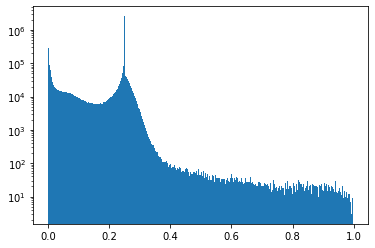

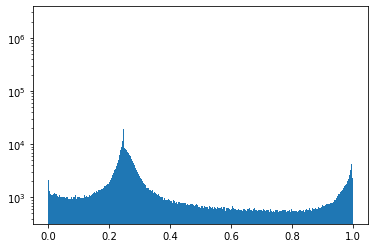

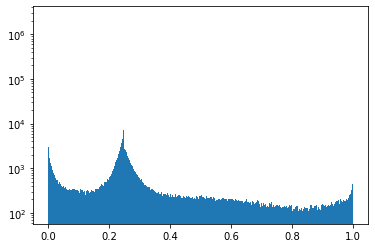

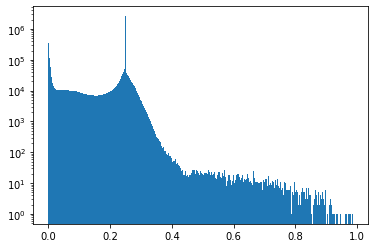

In [45]:

hist = plt.hist(yhat[:,:,0].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,1].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,2].reshape(-1), bins='auto', log=True)
plt.show()
hist = plt.hist(yhat[:,:,3].reshape(-1), bins='auto', log=True)
plt.show()